In [ ]:
import tensorflow as tf
from tensorflow import keras

# Predicting house prices: a regression example


Do not mix up "regression" with the algorithm "logistic regression": confusingly, "logistic regression" is not a regression algorithm,
it is a classification algorithm.

## The Boston Housing Price dataset


We will be attempting to predict the median price of homes in a given Boston suburb in the mid-1970s, given a few data points about the
suburb at the time, such as the crime rate, the local property tax rate, etc.

The dataset we will be using has another interesting difference from our two previous examples: it has very few data points, only 506 in
total, split between 404 training samples and 102 test samples, and each "feature" in the input data (e.g. the crime rate is a feature) has
a different scale. For instance some values are proportions, which take a values between 0 and 1, others take values between 1 and 12,
others between 0 and 100...

Let's take a look at the data:

In [ ]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [ ]:
train_data.shape

(404, 13)

In [ ]:
test_data.shape

(102, 13)


As you can see, we have 404 training samples and 102 test samples. The data comprises 13 features. The 13 features in the input data are as
follow:

1. Per capita crime rate.
2. Proportion of residential land zoned for lots over 25,000 square feet.
3. Proportion of non-retail business acres per town.
4. Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
5. Nitric oxides concentration (parts per 10 million).
6. Average number of rooms per dwelling.
7. Proportion of owner-occupied units built prior to 1940.
8. Weighted distances to five Boston employment centres.
9. Index of accessibility to radial highways.
10. Full-value property-tax rate per $10,000.
11. Pupil-teacher ratio by town.
12. 1000 * (Bk - 0.63) ** 2 where Bk is the proportion of Black people by town.
13. % lower status of the population.

The targets are the median values of owner-occupied homes, in thousands of dollars:

In [ ]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13


The prices are typically between \$10,000 and \$50,000. If that sounds cheap, remember this was the mid-1970s, and these prices are not
inflation-adjusted.

## Preparing the data


It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to
automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal
with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we
will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a
unit standard deviation. This is easily done in Numpy:

In [ ]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [ ]:
import numpy as np

data_num = train_data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation分為，這裡的劃分比例為8:2
train_indexes = indexes[:int(data_num *0.8)]
val_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
val_data = train_data[val_indexes]
train_data = train_data[train_indexes]
val_targets = train_targets[val_indexes]
train_targets = train_targets[train_indexes]


Note that the quantities that we use for normalizing the test data have been computed using the training data. We should never use in our
workflow any quantity computed on the test data, even for something as simple as data normalization.

## Building our network


Because so few samples are available, we will be using a very small network with two
hidden layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using
a small network is one way to mitigate overfitting.

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(13, )，而實際上我們輸入的數據形狀為(batch_size, 13)
model.add(layers.Dense(64, activation='relu', input_shape=(13,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                896       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [ ]:
import os

model_dir = 'lab1-logs/models/'
os.makedirs(model_dir)
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab1-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.keras',
                                        monitor='val_mean_absolute_error',
                                        save_best_only=True,
                                        mode='min')

In [ ]:
history = model.fit(train_data, train_targets,  # 傳入訓練數據
               batch_size=16,  # 批次大小設為16
               epochs=100,  # 整個dataset訓練100遍
               validation_data=(val_data, val_targets),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/100
21/21 [==============================] - 6s 66ms/step - loss: 549.8732 - mean_absolute_error: 21.5047 - val_loss: 523.8311 - val_mean_absolute_error: 21.1326
Epoch 2/100
21/21 [==============================] - 0s 22ms/step - loss: 455.3241 - mean_absolute_error: 19.1217 - val_loss: 405.2688 - val_mean_absolute_error: 18.1248
Epoch 3/100
21/21 [==============================] - 0s 24ms/step - loss: 315.0590 - mean_absolute_error: 15.2431 - val_loss: 233.0393 - val_mean_absolute_error: 13.0863
Epoch 4/100
21/21 [==============================] - 1s 33ms/step - loss: 153.2482 - mean_absolute_error: 9.8981 - val_loss: 95.1267 - val_mean_absolute_error: 7.2206
Epoch 5/100
21/21 [==============================] - 1s 27ms/step - loss: 70.7106 - mean_absolute_error: 6.2043 - val_loss: 61.4115 - val_mean_absolute_error: 5.7684
Epoch 6/100
21/21 [==============================] - 1s 26ms/step - loss: 47.1117 - mean_absolute_error: 5.0195 - val_loss: 43.0827 - val_mean_absolute_error

In [ ]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

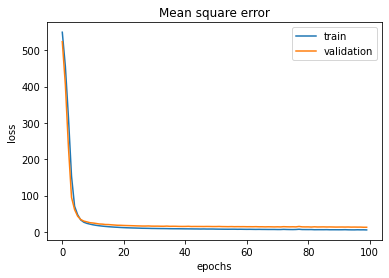

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

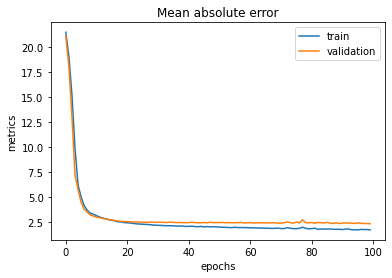

In [ ]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

In [ ]:
model = keras.models.load_model('lab1-logs/models/Best-model-1.keras')

# 預測測試數據
y_pred = model.predict(test_data)
print(y_pred.shape)
print(test_targets.shape)

# 不需要將預測結果轉換回來(因為訓練時的訓練目標並沒有經過標準化)
# y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)

y_pred = np.reshape(y_pred, test_targets.shape)
print(y_pred.shape, test_targets.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(test_targets - y_pred) / test_targets) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

4/4 [==============================] - 0s 3ms/step
(102, 1)
(102,)
(102,) (102,)
Model_1 Percentage Error: 13.63%


實驗二：過擬合問題

方法一、減少網路權重(減少神經元)


In [ ]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(13,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab1-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.keras',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min')
es = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=10)
model_2.fit(train_data, train_targets,  # 傳入訓練數據
               batch_size=16,  # 批次大小設為16
               epochs=100,  # 整個dataset訓練100遍
               validation_data=(val_data, val_targets),  # 驗證數據
               callbacks=[model_cbk, model_mckp, es])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/100
21/21 [==============================] - 1s 10ms/step - loss: 526.3845 - mean_absolute_error: 20.7155 - val_loss: 537.5537 - val_mean_absolute_error: 21.2311
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 497.6250 - mean_absolute_error: 19.9457 - val_loss: 506.3358 - val_mean_absolute_error: 20.4478
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 463.5217 - mean_absolute_error: 19.0240 - val_loss: 465.2427 - val_mean_absolute_error: 19.4017
Epoch 4/100
21/21 [==============================] - 0s 5ms/step - loss: 418.8663 - mean_absolute_error: 17.8801 - val_loss: 410.8989 - val_mean_absolute_error: 18.0642
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 361.0105 - mean_absolute_error: 16.3848 - val_loss: 341.2780 - val_mean_absolute_error: 16.2370
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 289.4609 - mean_absolute_error: 14.3607 - val_loss: 254.8513 - val_mean_absolute_

In [ ]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),
                         activation='relu', input_shape=(13,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab1-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.keras',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min')
es = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=10)
model_3.fit(train_data, train_targets,  # 傳入訓練數據
               batch_size=16,  # 批次大小設為16
               epochs=100,  # 整個dataset訓練100遍
               validation_data=(val_data, val_targets),  # 驗證數據
               callbacks=[model_cbk, model_mckp, es])

Epoch 1/100
21/21 [==============================] - 1s 12ms/step - loss: 556.0255 - mean_absolute_error: 21.6696 - val_loss: 536.9326 - val_mean_absolute_error: 21.5200
Epoch 2/100
21/21 [==============================] - 0s 5ms/step - loss: 473.6805 - mean_absolute_error: 19.8367 - val_loss: 432.1178 - val_mean_absolute_error: 19.1857
Epoch 3/100
21/21 [==============================] - 0s 6ms/step - loss: 344.0150 - mean_absolute_error: 16.5126 - val_loss: 263.8357 - val_mean_absolute_error: 14.5844
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 175.1798 - mean_absolute_error: 11.0984 - val_loss: 119.6266 - val_mean_absolute_error: 8.6169
Epoch 5/100
21/21 [==============================] - 0s 6ms/step - loss: 81.0384 - mean_absolute_error: 6.9575 - val_loss: 77.5849 - val_mean_absolute_error: 6.6615
Epoch 6/100
21/21 [==============================] - 0s 6ms/step - loss: 53.9752 - mean_absolute_error: 5.5758 - val_loss: 54.6134 - val_mean_absolute_error: 5

In [ ]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(13,)))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.keras',
                                             monitor='val_mean_absolute_error',
                                             save_best_only=True,
                                             mode='min')
es = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', mode='min', patience=10)
model_4.fit(train_data, train_targets,  # 傳入訓練數據
               batch_size=16,  # 批次大小設為16
               epochs=100,  # 整個dataset訓練100遍
               validation_data=(val_data, val_targets),  # 驗證數據
               callbacks=[model_cbk, model_mckp, es])

Epoch 1/100
21/21 [==============================] - 1s 12ms/step - loss: 554.2830 - mean_absolute_error: 21.6523 - val_loss: 539.7896 - val_mean_absolute_error: 21.5399
Epoch 2/100
21/21 [==============================] - 0s 6ms/step - loss: 479.0319 - mean_absolute_error: 19.8582 - val_loss: 438.8899 - val_mean_absolute_error: 19.1516
Epoch 3/100
21/21 [==============================] - 0s 5ms/step - loss: 354.6234 - mean_absolute_error: 16.5465 - val_loss: 276.2072 - val_mean_absolute_error: 14.6170
Epoch 4/100
21/21 [==============================] - 0s 6ms/step - loss: 197.8244 - mean_absolute_error: 11.4146 - val_loss: 124.7184 - val_mean_absolute_error: 8.5987
Epoch 5/100
21/21 [==============================] - 0s 5ms/step - loss: 97.8586 - mean_absolute_error: 7.3913 - val_loss: 73.7941 - val_mean_absolute_error: 6.2953
Epoch 6/100
21/21 [==============================] - 0s 5ms/step - loss: 65.6025 - mean_absolute_error: 6.1391 - val_loss: 53.3755 - val_mean_absolute_error: 5

In [ ]:
model = keras.models.load_model('lab1-logs/models/Best-model-2.keras')

# 預測測試數據
y_pred = model.predict(test_data)
print(y_pred.shape)
print(test_targets.shape)

# 不需要將預測結果轉換回來(因為訓練時的訓練目標並沒有經過標準化)
# y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)

y_pred = np.reshape(y_pred, test_targets.shape)
print(y_pred.shape, test_targets.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(test_targets - y_pred) / test_targets) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

4/4 [==============================] - 0s 3ms/step
(102, 1)
(102,)
(102,) (102,)
Model_1 Percentage Error: 17.10%


In [ ]:
model = keras.models.load_model('lab1-logs/models/Best-model-3.keras')

# 預測測試數據
y_pred = model.predict(test_data)
print(y_pred.shape)
print(test_targets.shape)

# 不需要將預測結果轉換回來(因為訓練時的訓練目標並沒有經過標準化)
# y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)

y_pred = np.reshape(y_pred, test_targets.shape)
print(y_pred.shape, test_targets.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(test_targets - y_pred) / test_targets) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

4/4 [==============================] - 0s 2ms/step
(102, 1)
(102,)
(102,) (102,)
Model_1 Percentage Error: 14.71%


In [ ]:
model = keras.models.load_model('lab1-logs/models/Best-model-4.keras')

# 預測測試數據
y_pred = model.predict(test_data)
print(y_pred.shape)
print(test_targets.shape)

# 不需要將預測結果轉換回來(因為訓練時的訓練目標並沒有經過標準化)
# y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)

y_pred = np.reshape(y_pred, test_targets.shape)
print(y_pred.shape, test_targets.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(test_targets - y_pred) / test_targets) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

4/4 [==============================] - 0s 3ms/step
(102, 1)
(102,)
(102,) (102,)
Model_1 Percentage Error: 15.62%
